In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
card_df=pd.read_csv('./creditcard.csv')
card_df.head(3) #3 rows × 31 columns
# 이상탐지 문제
# 레이블 [Class]1:사기거래 //  결재금액[Amount] // 컬럼명은 없이 성능 올려보는게 목적
# [Time]은 시퀀스, 순번으로 봐도 무방하고 크게 의미가 없으므로 삭제한다.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
card_df.info() # 284807 rows × 31 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# 전체 레이블의 균형성 확인
card_df['Class'].value_counts() # 0: 284315 , 1: 492

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
# 사기거래 비율 : 0.0017
# 매우 불균형한 데이터셋
rate = card_df['Class'].value_counts()[1]/card_df['Class'].count().sum()
print(f'사기거래 비율 : {rate:.4f}')

사기거래 비율 : 0.0017


---
### 데이터 전처리
---



In [6]:
# df를 복사해서 Time 피쳐 삭제 하고 df를 반환하는 함수 (4단계로 전처리 할때 사용)
def get_preprocessed_df(df=None):
    df_copy = df.copy() # 원본복사
    df_copy.drop('Time', axis=1, inplace=True) # Time 피쳐 삭제해서 리턴
    return df_copy

In [7]:
# 학습/테스트로 분리하는 함수
def get_train_test_dataset(df=None):  
    df_copy = get_preprocessed_df(df) # Time피쳐 drop
    # df_copy 데이터와 레이블 분리
    X_features = df_copy.iloc[:, :-1] # 데이터
    y_target = df_copy.iloc[:, -1] # 레이블
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.3, random_state=0, stratify=y_target
    )  # stratify=y_target: 불균형 셋 비율을 맞춰서 나눔
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환

In [8]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df) # 학습/테스트 분리

---
1. 전처리 없이 원본데이터
2. 표준정규화
3. 데이터로그 변환
4. 이상치 제거 - Amount 컬럼
5. smote 오버 샘플링

In [9]:
# 데이터 확인
print(y_train.value_counts())
print(y_train.shape) # 1차원 튜플 인덱스 있긴함 (199364,)

# 행렬곱으로 차원 맞춰진다. 전체합으로 나눠진다.
# 학습/테스트 레이블 분포 비율확인
print('학습 레이블 분포 비율: ', y_train.value_counts()/y_train.shape[0])   # 샘플 갯수로 나눔

# 테스트 레이블 분포 비율확인 : 둘다 비슷한 비율로 분리됨 확인
print('테스트 레이블 분포 비율: ', y_train.value_counts()/y_train.shape[0])   # 샘플 갯수로 나눔

Class
0    199020
1       344
Name: count, dtype: int64
(199364,)
학습 레이블 분포 비율:  Class
0    0.998275
1    0.001725
Name: count, dtype: float64
테스트 레이블 분포 비율:  Class
0    0.998275
1    0.001725
Name: count, dtype: float64


### 1. 원본 데이터 (가공 없이 모델 학습, 일반화 성능 확인)

In [10]:
# 1. 원본데이터로 성능 확인
# 불균형 레이블 평가시 : 정확도(accuracy)로 평가보다는 AUC(Area Under Curve)등 다른 점수 중요

# 평가결과를 출력하는 함수 (혼동행렬~AUC 점수를 출력 저장하도록 수정함)
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    # 결과저장
    result = {
        '오차행렬': confusion.tolist(),
        '정확도': round(accuracy,4),
        '정밀도': round(precision,4),
        '재현율': round(recall,4),
        'F1': round(f1,4),
        'AUC': round(roc_auc,4)
    }
    print(result)
    return result


In [11]:
# 저장할 딕셔너리 준비 : 모델별로 분리
lr_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

lgbm_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

xgb_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

# 결과(dict)를 받아 딕셔너리(dict)로 저장하는 함수(모델딕셔너리, 평가결과)
def add_result_dict(model_metric, model_result):
    if '오차행렬' in model_result:
        tn, fp = model_result['오차행렬'][0]  # 키값으로 선택하고 인덱스로 접근한다.
        fn, tp = model_result['오차행렬'][1]

        model_metric['TN'].append(tn)   # 입력하기
        model_metric['FP'].append(fp)
        model_metric['FN'].append(fn)
        model_metric['TP'].append(tp)

    # 나머지는 키값으로 바로 불러지므로 딕셔너리에 바로 추가
    for x in ['정확도', '정밀도', '재현율', 'F1', 'AUC']:
        if x in model_result: # 해당지표가 결과dict에 있다면 입력
            model_metric[x].append(model_result[x])

In [12]:
# 학습, 예측, 예측률, 평가(함수호출)하는 함수 (모델만 바꿔 넣어줌)

def get_model_train_eval(model,             # 사용할 모델
                         ftr_train=None,    # 학습
                         ftr_test=None,     # 테스트
                         tgt_train=None,    # 학습 레이블
                         tgt_test=None):    # 테스트 레이블
    model.fit(ftr_train, tgt_train)     # 학습
    pred=model.predict(ftr_test)        # 일반화 성능: 예측값
    pred_proba=model.predict_proba(ftr_test)[:,1] # 예측확률 (1 사기일 확률만 가져옴)
    # 평가함수 호출 : 일반화 성능 평가
    result = get_clf_eval(tgt_test, pred, pred_proba)
    return result # 결과물 반환: 시각화를 위해 딕셔너리에 저장하는 용도

In [13]:
# 함수 작동하는지 확인하는 코드

# 1 오브젝트 생성
lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear', # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2', # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

# 2 학습
lr_clf.fit(X_train,y_train)

# 3 모델 평가(일반화성능) : 예측값, 예측확률 필요
# 예측값 (0,1)
lr_pred = lr_clf.predict(X_test)
# 예측확률은 ([0일확률, 1일 확률]) 2차원으로 나옴
lr_pred_proba= lr_clf.predict_proba(X_test)[:,1] # 1일 확률만 : 사기거래 확률만 가져옴

# 4 평가 함수
get_clf_eval(y_test,lr_pred, lr_pred_proba)


# 정확도 높게 나온다: 레이블 99%가 0이기 때문
# (예측)정밀도, (실제)재현율, f1점수 등이 많이 떨어짐

# {'오차행렬': [[85281, 14], [58, 90]], '정확도': 0.9992, '정밀도': 0.8654, '재현율': 0.6081, 'F1': 0.7143, 'AUC': np.float64(0.9743)}

{'오차행렬': [[85281, 14], [56, 92]], '정확도': 0.9992, '정밀도': 0.8679, '재현율': 0.6216, 'F1': 0.7244, 'AUC': np.float64(0.9699)}


{'오차행렬': [[85281, 14], [56, 92]],
 '정확도': 0.9992,
 '정밀도': 0.8679,
 '재현율': 0.6216,
 'F1': 0.7244,
 'AUC': np.float64(0.9699)}

In [14]:
# 1 LR

lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear', # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2', # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

lr_result = get_model_train_eval(lr_clf,
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test) # 모델 학습/예측/평가 함수



# {'오차행렬': [[85282, 13], [57, 91]], '정확도': 0.9992, '정밀도': 0.875, '재현율': 0.6149, 'F1': 0.7222, 'AUC': np.float64(0.9739)}

{'오차행렬': [[85281, 14], [56, 92]], '정확도': 0.9992, '정밀도': 0.8679, '재현율': 0.6216, 'F1': 0.7244, 'AUC': np.float64(0.9699)}


In [15]:
# 2 lightgbm

lgbm_clf = LGBMClassifier(
    n_estimators=1000,
    num_leaves=64, # 트리하나가 가질수 있는 최대 리프개수
    verbose=-1,
    n_jobs=-1, 
    boost_from_average=False) # 극도로 불균형한 레이블 일경우 False로 설정

lgbm_result = get_model_train_eval(lgbm_clf,
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test) # 모델 학습/예측/평가 함수

# {'오차행렬': [[85290, 5], [36, 112]], '정확도': 0.9995, '정밀도': 0.9573, '재현율': 0.7568, 'F1': 0.8453, 'AUC': np.float64(0.979)}

{'오차행렬': [[85290, 5], [36, 112]], '정확도': 0.9995, '정밀도': 0.9573, '재현율': 0.7568, 'F1': 0.8453, 'AUC': np.float64(0.979)}


In [16]:
# 3 XGBoost 

xgb_clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    n_jobs=-1
)

xgb_result = get_model_train_eval(xgb_clf,
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test) # 모델 학습/예측/평가 함수



# 오차 행렬
# [[85290     5]
#  [   28   118]]
# 정확도: 0.9996, 정밀도: 0.9593, 재현율: 0.8082,    F1: 0.8773, AUC:0.9809

{'오차행렬': [[85289, 6], [39, 109]], '정확도': 0.9995, '정밀도': 0.9478, '재현율': 0.7365, 'F1': 0.8289, 'AUC': np.float64(0.9798)}


In [17]:
# 1 base 성능 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(lgbm_metric, lgbm_result)
add_result_dict(xgb_metric, xgb_result)

### 2. StandardScaler로 데이터 정규화

In [18]:
card_df['Amount'].max(), card_df['Amount'].min() # 결재금액의 최대값, 최소값 확인 # (25691.16, 0.0)


(25691.16, 0.0)

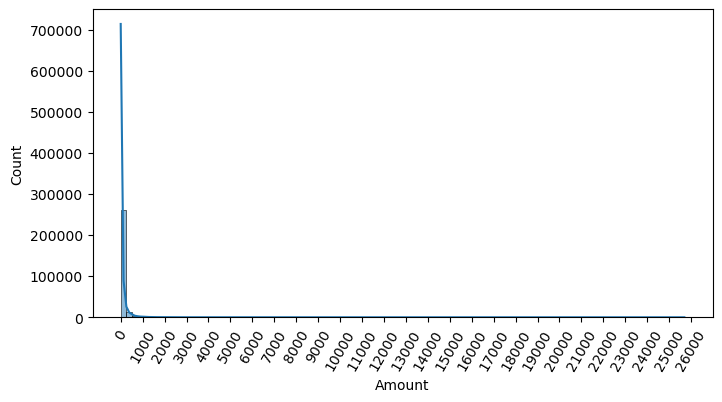

In [19]:
# 특정 피처의 데이터 분포 확인 Amount : 왜도 첨도

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True) # 각구간의 빈도수를 체크, bins=구간나누기(세로), kde: 분포 곡선
plt.show()

# 해석: 정상결재가 한쪽으로 몰려있다. 빈도가 낮고 금액이 큰 것이 이상치. 이상치 금액이 매우 높다.

In [20]:
# 왜도값 확인 : 데이터의 비대칭성 확인에 사용
# 양의 왜도 처리방식: 로그 변환(대표적)

# 첨도값 확인 : 극단값 존재 여부 확인
# 양의 첨도 처리: 극단값처리 필수, 적절한 모델(알고리즘) 선택 필요


print(skew(card_df['Amount']))      # 왜도값 확인 : 양의 왜도  16.97763503663315

print(kurtosis(card_df['Amount']))  # 첨도값 확인 : 845.0777883188754 뾰족한 그래프

16.97763503663315
845.0777883188754


In [21]:
# shapiro() : Amount 피처의 정규성 확인


stat, p = shapiro(card_df['Amount'].values)

print(f'통계량: {stat}')
print(f'p_value: {p}')

if p >0.05:
    print('정규성을 만족')
else:
    print('정규성 없음')

통계량: 0.31004461476982703
p_value: 6.536480219597055e-199
정규성 없음


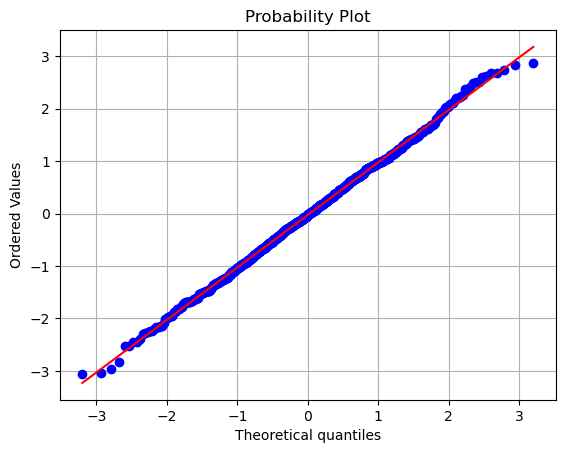

In [22]:
# 정규성 있는 데이터와 비교 : qq plot 정규분포를 따르는지 시각화하여 확인하는데 사용

data=np.random.normal(loc=0, scale=1, size=1000)

# qq plot 생성
stats.probplot(data, dist='norm', plot=plt) # dist='norm' 정규분보와 비교

plt.grid()
plt.show()


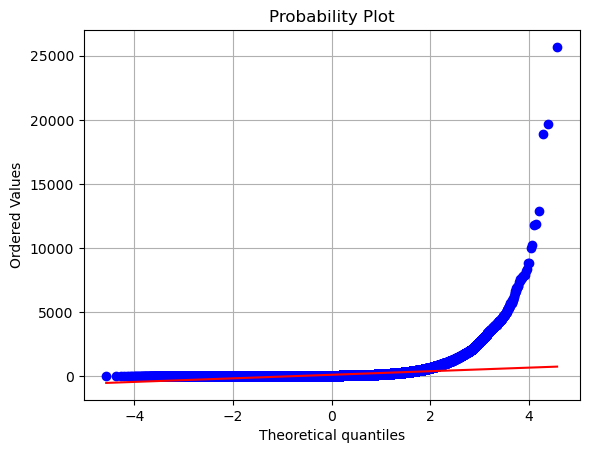

In [23]:
# Amount 피쳐 시각화하여 정규분포와 비교
stats.probplot(card_df['Amount'].values, dist='norm', plot=plt)

plt.grid()
plt.show()

In [24]:
# 2.StandardScaler적용하고 정규분포에 가까와지는지 확인

# Amount 피처 : 평균 표준편차 왜도 첨도 구하기 :원본
avg_amount=card_df['Amount'].mean()
std_amount=card_df['Amount'].std()
skew_amount=skew(card_df['Amount'])
kurtosis_amount=kurtosis(card_df['Amount'])

# SS 적용
scaler=StandardScaler()
ss_amount=scaler.fit_transform(card_df['Amount'].values.reshape(-1,1)) # 2차원으로 변환

print(f'원본데이터의 평균: {avg_amount}, \n표준편차: {std_amount}, \n왜도: {skew_amount}, \n첨도: {kurtosis_amount}')
print()
print(f'SS 적용한 데이터의 평균: {ss_amount.mean()}, \n표준편차: {ss_amount.std()}, \n왜도: {skew(ss_amount)}, \n첨도: {kurtosis(ss_amount)}')

# 정규분포로 바뀌지는 않는다 = SS해도 왜도 첨도가 바뀌진 않음 (주의)
# 표준화만 됨 (일정범위로 만들어 서로 비교되도록 하는 정도임)

# 원본데이터의 평균: 88.34961925093133,
# 표준편차: 250.1201092402221,
# 왜도: 16.97763503663315,
# 첨도: 845.0777883188754

# SS 적용한 데이터의 평균: 2.913951958230651e-17,
# 표준편차: 1.0,
# 왜도: 16.97763504,
# 첨도: 845.07778832

원본데이터의 평균: 88.34961925093133, 
표준편차: 250.1201092402221, 
왜도: 16.97763503663315, 
첨도: 845.0777883188754

SS 적용한 데이터의 평균: 2.913951958230651e-17, 
표준편차: 1.0, 
왜도: [16.97763504], 
첨도: [845.07778832]


### 3. 로그변환

In [25]:
# 전처리 함수 수정 : np.log1p 적용
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n=np.log1p(df_copy['Amount'])    # 로그함수 적용
    df_copy.insert(0,'Amount_Scaled', amount_n) # 재입력
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 전처리된 df 반환
    return df_copy

In [26]:
# 원본 데이터프레임에 로그함수로 전처리
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [27]:
X_train.head() # 적용되었는지 확인

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
211605,0.524729,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,...,-0.750795,3.589299,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504
231628,4.033710,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,...,-0.059595,0.057620,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879
110643,2.525729,-0.606860,0.233923,2.633361,-0.155762,-0.328850,-0.070593,0.173023,0.113394,0.680147,...,-1.003842,-0.129287,0.007393,0.265045,-0.040615,0.406088,-0.498823,0.121851,-0.046840,-0.087259
11478,2.397895,1.374168,-0.330389,0.812971,-0.183112,-1.074771,-0.933788,-0.544238,-0.348237,0.614925,...,0.603330,0.078163,-0.134742,0.016793,0.002610,0.714527,0.536175,-0.307487,-0.003555,0.013024
243724,7.736766,-2.146505,-7.603113,-4.928224,1.449173,-2.083871,-0.984759,3.629816,-1.302973,-1.434148,...,-1.373723,4.009181,1.274986,-0.857670,-2.109682,0.169338,-0.322888,0.777822,-0.552258,0.304777


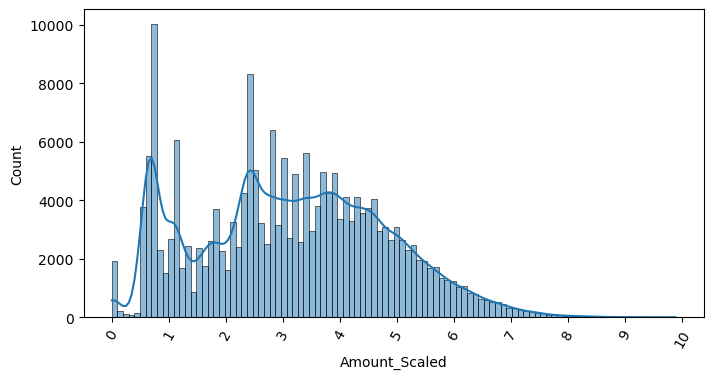

0.1624089300266736
-0.6373140468164058


In [28]:
# 데이터 분포 확인 Amount : 왜도 첨도

plt.figure(figsize=(8,4))
plt.xticks(range(0,11,1), rotation=60)
sns.histplot(X_train['Amount_Scaled'], bins=100, kde=True) # 각구간의 빈도수를 체크, bins=구간나누기(세로), kde: 분포 곡선
plt.show()

print(skew(X_train['Amount_Scaled'])) # 왜도값 확인: 0.1624089300266736 / 원본데이터 왜도  16.97763503663315

print(kurtosis(X_train['Amount_Scaled'])) # 첨도값 확인: -0.6373140468164058 / 원본데이터 첨도 845.0777883188754 뾰족한 그래프

In [29]:
# 2 로그처리후 성능
print('### 로그처리후: LR')
lr_result = get_model_train_eval(lr_clf,
                     ftr_train = X_train,
                     ftr_test = X_test,
                     tgt_train = y_train,
                     tgt_test = y_test
                     )


print('### 로그처리후: LGBM')
lgbm_result = get_model_train_eval(lgbm_clf,
                     ftr_train = X_train,
                     ftr_test = X_test,
                     tgt_train = y_train,
                     tgt_test = y_test
                     )

# 2 로그처리후 성능

print('### 로그처리후: XGB')
xgb_result = get_model_train_eval(xgb_clf,
                     ftr_train = X_train,
                     ftr_test = X_test,
                     tgt_train = y_train,
                     tgt_test = y_test
                     )



### 로그처리후: LR
{'오차행렬': [[85283, 12], [59, 89]], '정확도': 0.9992, '정밀도': 0.8812, '재현율': 0.6014, 'F1': 0.7149, 'AUC': np.float64(0.9723)}
### 로그처리후: LGBM
{'오차행렬': [[85290, 5], [35, 113]], '정확도': 0.9995, '정밀도': 0.9576, '재현율': 0.7635, 'F1': 0.8496, 'AUC': np.float64(0.9796)}
### 로그처리후: XGB
{'오차행렬': [[85289, 6], [39, 109]], '정확도': 0.9995, '정밀도': 0.9478, '재현율': 0.7365, 'F1': 0.8289, 'AUC': np.float64(0.9798)}


In [30]:
# 2 log처리 결과 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(lgbm_metric, lgbm_result)
add_result_dict(xgb_metric, xgb_result)

### 4. 이상치 제거  (IQR)

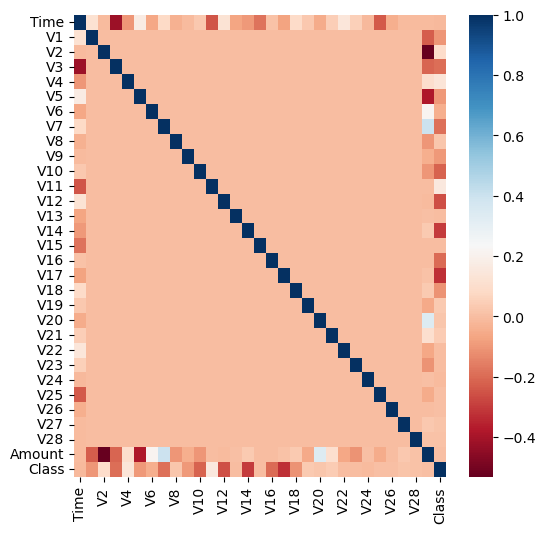

In [31]:
# 3. 이상치 outliers 찾기 - 피처간의 관계 시각화하기
# 3.1 상관계수 확인
# 어떤 피처의 이상치를 검출할 것인가 -> 레이블과 가장 상관성 높은 피처 위주로 검출

plt.figure(figsize=(6,6))
corr = card_df.corr()   # 각 피처들간의 상관계수

sns.heatmap(corr, cmap='RdBu')
plt.show()
# 14, 17 음의 상관관계가 가장 높게 나옴

In [32]:
# IQR(Interquartile Range): Q3- Q1, 데이터의 중심 50% 범위
# 이상치 데이터의 인덱스를 반환하는 함수 outlier index

# df=card_df :원래 데이터의 이상치 점검하기
# column='V14'
def get_outlier(df=None, column=None, weight=1.5):
    #  fraud(class==1)에 해당하는 컬럼만 추출, 사분위(Q1,Q3) 지점을 구함
    fraud = df[df['Class']==1][column] # 492개 시리즈 나온다
    # Q1, Q3 위치의 값
    q_25 = np.percentile(fraud.values, 25)
    q_75 = np.percentile(fraud.values, 75)
    # IQR구해서 1.5 곱하기
    iqr = q_75 - q_25
    iqr_weight = iqr * weight
    low_value = q_25 - iqr_weight   # min : 원래 최소값에 가중치를 더해 더 작게
    high_value = q_75 + iqr_weight  # max : 원래 최대값에 가중치를 더해 더 크게
    outlier_index = fraud[(fraud < low_value) | (fraud > high_value)].index  # 이 범위에서 벗어난다면 이상치이다.
    return outlier_index  #이상치의 인덱스 값

In [33]:
# 이상치 찾아주는 함수 ==> 데이터에서 제거할 예정
outlier_index=get_outlier(df=card_df, column='V14')
print(f'이상치 데이터의 인덱스 : {outlier_index}')

# 이상치 데이터의 인덱스 : Index([8296, 8615, 9035, 9252], dtype='int64')

이상치 데이터의 인덱스 : Index([8296, 8615, 9035, 9252], dtype='int64')


In [34]:
# 함수에 들어가 있는 Q1, Q3 위치의 값, iqr 확인
fraud = card_df[card_df['Class']==1]['V14']
q1=np.percentile(fraud.values, 25)
q3=np.percentile(fraud.values, 75)
iqr = q3-q1
print(f'q1 : {q1}, q3 : {q3}, IQR value : {iqr}')

q1 : -9.692722964972386, q3 : -4.282820849486865, IQR value : 5.409902115485521


In [35]:
# get_preprocessed_df() 에 이상치 제거 하는 기능 추가
# 로그변환, 이상치 제거 추가
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    # Amount feature만 로그변환
    amount_n=np.log1p(df_copy['Amount'])
    # 로그변환한 피처를 데이터프레임에 삽입(insert)
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)
    # 이상치 데이터 제거
    outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [36]:
# 데이터 분리
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

In [37]:
# 3 이상치 제거

print('### 전체데이터 이상치 제거: LR')
lr_result = get_model_train_eval(
        lr_clf, ftr_train=X_train,
        ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

print('### 전체데이터 이상치 제거: LGBM')
lgbm_result = get_model_train_eval(
        lgbm_clf, ftr_train=X_train,
        ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

print('### 전체데이터 이상치 제거: XGB')
xgb_result = get_model_train_eval(
        xgb_clf, ftr_train=X_train,
        ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)


### 전체데이터 이상치 제거: LR
{'오차행렬': [[85281, 14], [48, 98]], '정확도': 0.9993, '정밀도': 0.875, '재현율': 0.6712, 'F1': 0.7597, 'AUC': np.float64(0.9741)}
### 전체데이터 이상치 제거: LGBM
{'오차행렬': [[85290, 5], [25, 121]], '정확도': 0.9996, '정밀도': 0.9603, '재현율': 0.8288, 'F1': 0.8897, 'AUC': np.float64(0.978)}
### 전체데이터 이상치 제거: XGB
{'오차행렬': [[85290, 5], [28, 118]], '정확도': 0.9996, '정밀도': 0.9593, '재현율': 0.8082, 'F1': 0.8773, 'AUC': np.float64(0.9809)}


In [38]:
# 3 이상치 제거 결과 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(lgbm_metric, lgbm_result)
add_result_dict(xgb_metric, xgb_result)

In [39]:
y_test[y_test == 1].shape

(146,)

In [40]:
y_idx = y_train[y_train == 1].index
y_idx.shape

(342,)

In [41]:
# 답에서 이상치를 가져와서 데이터에서 골라내기 
X_train_selected = X_train.loc[y_idx] 
X_train_selected.shape

(342, 29)

In [42]:
X_train_selected['V14']

59539     -3.455197
150684    -8.728645
153823    -7.383370
53591     -4.634631
6774      -7.019902
            ...    
48094     -5.208305
106998    -5.591364
79874     -1.635145
42609    -13.044182
146790    -1.016916
Name: V14, Length: 342, dtype: float64

In [43]:
# 훈련데이터의 Q1, Q3 위치의 값, iqr 확인
q1=np.percentile(X_train_selected.values, 25)
q3=np.percentile(X_train_selected.values, 75)
iqr = q3-q1
print('q1 ', q1,' q3 ', q3, ' iqr ', iqr )

q1  -2.450324405773385  q3  0.7459531236627717  iqr  3.1962775294361565


In [44]:
# 테스트데이터의 이상치 점검하기
# column='V14'
def get_outlier(y=None, x=None, column=None, weight=1.5):
    #  fraud(class==1)에 해당하는 컬럼만 추출, 사분위(Q1,Q3) 지점을 구함
    fraud_y_idx = y[y==1].index # 답에서 이상치를 가져와서 데이터에서 골라내기
    fraud_X_selected= x.loc[fraud_y_idx]['V14']
    # Q1, Q3 위치의 값
    q_25 = np.percentile(fraud_X_selected.values, 25)
    q_75 = np.percentile(fraud_X_selected.values, 75)
    # IQR구해서 1.5 곱하기
    iqr = q_75 - q_25
    iqr_weight = iqr * weight
    low_value = q_25 - iqr_weight   # min : 원래 최소값에 가중치를 더해 더 작게
    high_value = q_75 + iqr_weight  # max : 원래 최대값에 가중치를 더해 더 크게
    outlier_index = fraud_X_selected[(fraud_X_selected < low_value) | (fraud_X_selected > high_value)].index  # 이 범위에서 벗어난다면 이상치이다.
    return outlier_index  #이상치의 인덱스 값

In [45]:
# 이상치 찾아주는 함수 ==> 데이터에서 제거할 예정
outlier_index=get_outlier(y=y_train, x=X_train, column='V14')
print(f'테스트데이터의 이상치 인덱스 : {outlier_index}')

# 원본데이터의 이상치 인덱스 : Index([8296, 8615, 9035, 9252], dtype='int64')

테스트데이터의 이상치 인덱스 : Index([9487, 154286, 9509, 41943], dtype='int64')


In [46]:
# 로그변환

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    # Amount feature만 로그변환
    amount_n=np.log1p(df_copy['Amount'])
    # 로그변환한 피처를 데이터프레임에 삽입(insert)
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)

    return df_copy

In [47]:
# 학습/테스트로 분리하는 함수 : 이상치 제거
def get_train_test_dataset(df=None):  
    df_copy = get_preprocessed_df(df) # Time피쳐 drop, 로그변환
    # df_copy 데이터와 레이블 분리
    X_features = df_copy.iloc[:, :-1] # 데이터
    y_target = df_copy.iloc[:, -1] # 레이블
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)  
    # 이상치 데이터 제거
    outlier_index=get_outlier(y=y_train, x=X_train, column='V14', weight=1.45)
    X_train.drop(outlier_index, axis=0, inplace=True) 
    y_train.drop(outlier_index, axis=0, inplace=True) 

    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환


In [48]:
# 데이터 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df) # 학습/테스트 분리

In [49]:
# 3 이상치 제거

print('### 이상치 제거: LR')
lr_result = get_model_train_eval(
        lr_clf, ftr_train=X_train,
        ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

print('### 이상치 제거: LGBM')
lgbm_result = get_model_train_eval(
        lgbm_clf, ftr_train=X_train,
        ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

print('### 이상치 제거: XGB')
xgb_result = get_model_train_eval(
        xgb_clf, ftr_train=X_train,
        ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)


### 이상치 제거: LR
{'오차행렬': [[85282, 13], [59, 89]], '정확도': 0.9992, '정밀도': 0.8725, '재현율': 0.6014, 'F1': 0.712, 'AUC': np.float64(0.9712)}
### 이상치 제거: LGBM
{'오차행렬': [[85291, 4], [38, 110]], '정확도': 0.9995, '정밀도': 0.9649, '재현율': 0.7432, 'F1': 0.8397, 'AUC': np.float64(0.9794)}
### 이상치 제거: XGB
{'오차행렬': [[85289, 6], [40, 108]], '정확도': 0.9995, '정밀도': 0.9474, '재현율': 0.7297, 'F1': 0.8244, 'AUC': np.float64(0.9803)}


In [50]:
# 3 이상치 제거 결과 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(lgbm_metric, lgbm_result)
add_result_dict(xgb_metric, xgb_result)

### 4 . 오버샘플링

In [51]:
# 4 . 오버샘플링 SMOTE 적용후 데이터 확인하기: 원본데이터 변화 확인
# SMOTE는 불균형 데이터셋에서 기존 분포를 기본으로 소수 클래스를 가상으로 생성하여 균형을 맞춰준다.

smote=SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)

print('SMOTE 적용전 학습용 피처/레이블 구조: ' , X_train.shape, y_train.shape)
print('SMOTE 적용후 학습 피처/레이블 구조: ' , X_train_over.shape, y_train_over.shape)

print('SMOTE 적용전 레이블값 분포: ' , pd.Series(y_train).value_counts())
print('SMOTE 적용후 레이블값 분포: ' , pd.Series(y_train_over).value_counts())


SMOTE 적용전 학습용 피처/레이블 구조:  (199360, 29) (199360,)
SMOTE 적용후 학습 피처/레이블 구조:  (398040, 29) (398040,)
SMOTE 적용전 레이블값 분포:  Class
0    199020
1       340
Name: count, dtype: int64
SMOTE 적용후 레이블값 분포:  Class
0    199020
1    199020
Name: count, dtype: int64


In [52]:
# 4.2  오버샘플링 SMOTE : 비율 조정 : 이상거래를 50% 수준으로 변경

smote=SMOTE(random_state=0, sampling_strategy=0.5)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)

print('SMOTE 적용전 학습용 피처/레이블 구조: ' , X_train.shape, y_train.shape)
print('SMOTE 적용후 학습 피처/레이블 구조: ' , X_train_over.shape, y_train_over.shape)
print('SMOTE 적용전 레이블값 분포: ' , pd.Series(y_train).value_counts())
print('SMOTE 적용후 레이블값 분포: ' , pd.Series(y_train_over).value_counts())


SMOTE 적용전 학습용 피처/레이블 구조:  (199360, 29) (199360,)
SMOTE 적용후 학습 피처/레이블 구조:  (298530, 29) (298530,)
SMOTE 적용전 레이블값 분포:  Class
0    199020
1       340
Name: count, dtype: int64
SMOTE 적용후 레이블값 분포:  Class
0    199020
1     99510
Name: count, dtype: int64


In [53]:
# 로그변환

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    # Amount feature만 로그변환
    amount_n=np.log1p(df_copy['Amount'])
    # 로그변환한 피처를 데이터프레임에 삽입(insert)
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1, inplace=True)

    return df_copy

In [54]:
# 학습/테스트로 분리하는 함수 : 이상치 제거 : 오버샘플링 (sampling_strategy=0.8)
def get_train_test_dataset(df=None):  
    df_copy = get_preprocessed_df(df) # Time피쳐 drop, 로그변환
    # df_copy 데이터와 레이블 분리
    X_features = df_copy.iloc[:, :-1] # 데이터
    y_target = df_copy.iloc[:, -1] # 레이블
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)  
    # 이상치 데이터 제거
    outlier_index=get_outlier(y=y_train, x=X_train, column='V14', weight=1.45)
    X_train.drop(outlier_index, axis=0, inplace=True) 
    y_train.drop(outlier_index, axis=0, inplace=True) 
    # 오버샘플링 SMOTE 적용
    smote=SMOTE(random_state=0, sampling_strategy=0.8)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환


In [55]:
# 데이터 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df) # 학습/테스트 분리

In [56]:
# lr
print('### SMOTE : LR')
lr_result = get_model_train_eval(
    lr_clf,
    ftr_train=X_train,
    ftr_test=X_test,
    tgt_train=y_train,
    tgt_test=y_test
)

# lgbm

print('### SMOTE : LGBM')
lgbm_result = get_model_train_eval(
    lgbm_clf,
    ftr_train=X_train,
    ftr_test=X_test,
    tgt_train=y_train,
    tgt_test=y_test
)

# XGB

print('### SMOTE : XGB')
xgb_result = get_model_train_eval(
    xgb_clf,
    ftr_train=X_train,
    ftr_test=X_test,
    tgt_train=y_train,
    tgt_test=y_test
)



### SMOTE : LR
{'오차행렬': [[83768, 1527], [15, 133]], '정확도': 0.982, '정밀도': 0.0801, '재현율': 0.8986, 'F1': 0.1471, 'AUC': np.float64(0.9802)}
### SMOTE : LGBM
{'오차행렬': [[85284, 11], [32, 116]], '정확도': 0.9995, '정밀도': 0.9134, '재현율': 0.7838, 'F1': 0.8436, 'AUC': np.float64(0.9853)}
### SMOTE : XGB
{'오차행렬': [[85258, 37], [30, 118]], '정확도': 0.9992, '정밀도': 0.7613, '재현율': 0.7973, 'F1': 0.7789, 'AUC': np.float64(0.9759)}


In [57]:
# 3 이상치 제거 결과 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(lgbm_metric, lgbm_result)
add_result_dict(xgb_metric, xgb_result)

In [58]:
# 학습/테스트로 분리하는 함수 : 이상치 제거 : 오버샘플링 (sampling_strategy=0.3)
def get_train_test_dataset(df=None):  
    df_copy = get_preprocessed_df(df) # Time피쳐 drop, 로그변환
    # df_copy 데이터와 레이블 분리
    X_features = df_copy.iloc[:, :-1] # 데이터
    y_target = df_copy.iloc[:, -1] # 레이블
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)  
    # 이상치 데이터 제거
    outlier_index=get_outlier(y=y_train, x=X_train, column='V14', weight=1.45)
    X_train.drop(outlier_index, axis=0, inplace=True) 
    y_train.drop(outlier_index, axis=0, inplace=True) 
    # 오버샘플링 SMOTE 적용
    smote=SMOTE(random_state=0, sampling_strategy=0.3)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환


In [59]:
# 데이터 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df) # 학습/테스트 분리

In [60]:
# lr
print('### SMOTE(조정) : LR')
lr_result = get_model_train_eval(
    lr_clf,
    ftr_train=X_train,
    ftr_test=X_test,
    tgt_train=y_train,
    tgt_test=y_test
)

# lgbm

print('### SMOTE(조정) : LGBM')
lgbm_result = get_model_train_eval(
    lgbm_clf,
    ftr_train=X_train,
    ftr_test=X_test,
    tgt_train=y_train,
    tgt_test=y_test
)

# XGB
print('### SMOTE(조정) : XGB')
xgb_result = get_model_train_eval(
    xgb_clf,
    ftr_train=X_train,
    ftr_test=X_test,
    tgt_train=y_train,
    tgt_test=y_test
)



### SMOTE(조정) : LR
{'오차행렬': [[84707, 588], [21, 127]], '정확도': 0.9929, '정밀도': 0.1776, '재현율': 0.8581, 'F1': 0.2943, 'AUC': np.float64(0.9812)}
### SMOTE(조정) : LGBM
{'오차행렬': [[85283, 12], [31, 117]], '정확도': 0.9995, '정밀도': 0.907, '재현율': 0.7905, 'F1': 0.8448, 'AUC': np.float64(0.9837)}
### SMOTE(조정) : XGB
{'오차행렬': [[85278, 17], [32, 116]], '정확도': 0.9994, '정밀도': 0.8722, '재현율': 0.7838, 'F1': 0.8256, 'AUC': np.float64(0.9777)}


In [61]:
# 4 이상치 제거 결과 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(lgbm_metric, lgbm_result)
add_result_dict(xgb_metric, xgb_result)

전처리별 데이터 프레임으로 저장

In [62]:
lr_metric, lgbm_metric, xgb_metric

({'TN': [85281, 85283, 85281, 85282, 83768, 84707],
  'FP': [14, 12, 14, 13, 1527, 588],
  'FN': [56, 59, 48, 59, 15, 21],
  'TP': [92, 89, 98, 89, 133, 127],
  '정확도': [0.9992, 0.9992, 0.9993, 0.9992, 0.982, 0.9929],
  '정밀도': [0.8679, 0.8812, 0.875, 0.8725, 0.0801, 0.1776],
  '재현율': [0.6216, 0.6014, 0.6712, 0.6014, 0.8986, 0.8581],
  'F1': [0.7244, 0.7149, 0.7597, 0.712, 0.1471, 0.2943],
  'AUC': [np.float64(0.9699),
   np.float64(0.9723),
   np.float64(0.9741),
   np.float64(0.9712),
   np.float64(0.9802),
   np.float64(0.9812)]},
 {'TN': [85290, 85290, 85290, 85291, 85284, 85283],
  'FP': [5, 5, 5, 4, 11, 12],
  'FN': [36, 35, 25, 38, 32, 31],
  'TP': [112, 113, 121, 110, 116, 117],
  '정확도': [0.9995, 0.9995, 0.9996, 0.9995, 0.9995, 0.9995],
  '정밀도': [0.9573, 0.9576, 0.9603, 0.9649, 0.9134, 0.907],
  '재현율': [0.7568, 0.7635, 0.8288, 0.7432, 0.7838, 0.7905],
  'F1': [0.8453, 0.8496, 0.8897, 0.8397, 0.8436, 0.8448],
  'AUC': [np.float64(0.979),
   np.float64(0.9796),
   np.float64(0.978)

In [63]:
# 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

stages = ['원본 데이터', '로그 변환', '전체데이터의 이상치 제거', '훈련데이터의 이상치 제거', 'SMOTE 적용', 'SMOTE 적용 2']

In [64]:
dfs = []
for i in range(len(stages)):  # 각 단계별로 데이터프레임 생성
    df = pd.DataFrame({
            # '모델': ['Logistic Regression', 'LGBM', 'XGBoost'],
            'TN': [lr_metric['TN'][i], lgbm_metric['TN'][i], xgb_metric['TN'][i]],
            'FP': [lr_metric['FP'][i], lgbm_metric['FP'][i], xgb_metric['FP'][i]],
            'FN': [lr_metric['FN'][i], lgbm_metric['FN'][i], xgb_metric['FN'][i]],
            'TP': [lr_metric['TP'][i], lgbm_metric['TP'][i], xgb_metric['TP'][i]],
            '정확도': [lr_metric['정확도'][i], lgbm_metric['정확도'][i], xgb_metric['정확도'][i]],
            '정밀도': [lr_metric['정밀도'][i], lgbm_metric['정밀도'][i], xgb_metric['정밀도'][i]],
            '재현율': [lr_metric['재현율'][i], lgbm_metric['재현율'][i], xgb_metric['재현율'][i]],
            'F1': [lr_metric['F1'][i], lgbm_metric['F1'][i], xgb_metric['F1'][i]],
            'AUC': [lr_metric['AUC'][i], lgbm_metric['AUC'][i], xgb_metric['AUC'][i]]
    }, index=['Logistic Regression', 'LGBM', 'XGBoost'])
    df.index.name = stages[i]  # 인덱스 이름 설정 (전처리 단계)
    dfs.append(df)

dfs[0]

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
원본 데이터,,,,,,,,,
Logistic Regression,85281,14,56,92,0.9992,0.8679,0.6216,0.7244,0.9699
LGBM,85290,5,36,112,0.9995,0.9573,0.7568,0.8453,0.9790
XGBoost,85289,6,39,109,0.9995,0.9478,0.7365,0.8289,0.9798


In [65]:
dfs[1]

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
로그 변환,,,,,,,,,
Logistic Regression,85283,12,59,89,0.9992,0.8812,0.6014,0.7149,0.9723
LGBM,85290,5,35,113,0.9995,0.9576,0.7635,0.8496,0.9796
XGBoost,85289,6,39,109,0.9995,0.9478,0.7365,0.8289,0.9798


In [66]:
dfs[2]

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
전체데이터의 이상치 제거,,,,,,,,,
Logistic Regression,85281,14,48,98,0.9993,0.8750,0.6712,0.7597,0.9741
LGBM,85290,5,25,121,0.9996,0.9603,0.8288,0.8897,0.9780
XGBoost,85290,5,28,118,0.9996,0.9593,0.8082,0.8773,0.9809


In [67]:
dfs[3]

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
훈련데이터의 이상치 제거,,,,,,,,,
Logistic Regression,85282,13,59,89,0.9992,0.8725,0.6014,0.7120,0.9712
LGBM,85291,4,38,110,0.9995,0.9649,0.7432,0.8397,0.9794
XGBoost,85289,6,40,108,0.9995,0.9474,0.7297,0.8244,0.9803


In [68]:
dfs[4]

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
SMOTE 적용,,,,,,,,,
Logistic Regression,83768,1527,15,133,0.9820,0.0801,0.8986,0.1471,0.9802
LGBM,85284,11,32,116,0.9995,0.9134,0.7838,0.8436,0.9853
XGBoost,85258,37,30,118,0.9992,0.7613,0.7973,0.7789,0.9759


모델별 변화량

In [69]:
# 데이터테이블2 모델별로 전처리에 따른 변화
lr_df = pd.DataFrame(lr_metric, index=stages)
lgbm_df = pd.DataFrame(lgbm_metric, index=stages)
xgb_df = pd.DataFrame(xgb_metric, index=stages)

In [70]:
lr_df

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
원본 데이터,85281,14,56,92,0.9992,0.8679,0.6216,0.7244,0.9699
로그 변환,85283,12,59,89,0.9992,0.8812,0.6014,0.7149,0.9723
전체데이터의 이상치 제거,85281,14,48,98,0.9993,0.8750,0.6712,0.7597,0.9741
훈련데이터의 이상치 제거,85282,13,59,89,0.9992,0.8725,0.6014,0.7120,0.9712
SMOTE 적용,83768,1527,15,133,0.9820,0.0801,0.8986,0.1471,0.9802
SMOTE 적용 2,84707,588,21,127,0.9929,0.1776,0.8581,0.2943,0.9812


In [71]:
lgbm_df

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
원본 데이터,85290,5,36,112,0.9995,0.9573,0.7568,0.8453,0.9790
로그 변환,85290,5,35,113,0.9995,0.9576,0.7635,0.8496,0.9796
전체데이터의 이상치 제거,85290,5,25,121,0.9996,0.9603,0.8288,0.8897,0.9780
훈련데이터의 이상치 제거,85291,4,38,110,0.9995,0.9649,0.7432,0.8397,0.9794
SMOTE 적용,85284,11,32,116,0.9995,0.9134,0.7838,0.8436,0.9853
SMOTE 적용 2,85283,12,31,117,0.9995,0.9070,0.7905,0.8448,0.9837


In [72]:
xgb_df

,TN,FP,FN,TP,정확도,정밀도,재현율,F1,AUC
원본 데이터,85289,6,39,109,0.9995,0.9478,0.7365,0.8289,0.9798
로그 변환,85289,6,39,109,0.9995,0.9478,0.7365,0.8289,0.9798
전체데이터의 이상치 제거,85290,5,28,118,0.9996,0.9593,0.8082,0.8773,0.9809
훈련데이터의 이상치 제거,85289,6,40,108,0.9995,0.9474,0.7297,0.8244,0.9803
SMOTE 적용,85258,37,30,118,0.9992,0.7613,0.7973,0.7789,0.9759
SMOTE 적용 2,85278,17,32,116,0.9994,0.8722,0.7838,0.8256,0.9777
